In [143]:
#imports
import pandas as pd     
import matplotlib.pyplot as plt    
%matplotlib inline
import seaborn as sns    
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import os
sns.set(style="darkgrid")
from math import pi
from glob import glob
import re
import math
import scipy.interpolate as interp
from tslearn.metrics import dtw, dtw_path
from dtw import dtw,accelerated_dtw

#### Get Data

In [144]:
# Reference: https://perials.com/getting-csv-files-directory-subdirectories-using-python/
def getData(PATH, name):
#     PATH = "happinessData/"

    EXT = "*.csv"
    files = [file for path, subdir, files in os.walk(PATH)
                for file in glob(os.path.join(path, EXT))]
    l = []
    for f in files:
        df = pd.read_csv(f)
        result = re.search('/(.*).csv', f)
#         r = re.search('/(.*)',str(result.group(1)))
        video = result.group(1)
        df['video'] = np.full(len(df), video, dtype = int)
        l.append(df)
    df = pd.concat(l, ignore_index=True)
    df['name'] = name
    df = df.rename(columns=lambda x: x.strip())
    return df

#### Processing Data

In [145]:
def processData(df):
    df = df[df['success'] != 0]
    df = df[df['confidence'] > 0.80]
    # extracting features
    au = [ 'timestamp','face_id','video', 'gaze_angle_x', 'gaze_angle_y', 'pose_Rx', 'pose_Ry', 'pose_Rz']
    for x in df.columns:
        if '_r' in x and 'AU' in x:
            au.append(x)
    df = df[au]
    return df

In [146]:
# df = pd.DataFrame()
# df = getData("happiness_csv/", "happiness")
# df = processData(df)

In [147]:
df.to_csv("anger/anger_data.csv")

#### Process Data

Get Single Person Data - keep the most occuring face_id
Keep videos with more than 5 and less than 50 frames

In [148]:
df = pd.read_csv('sadness/sadness_data.csv')
df = df.drop(columns = 'Unnamed: 0')

In [149]:
videos = set(df['video'])
toRemove = []

for i in videos:
    lst = df[df['video']==i]['video'].tolist()
    if len(lst) <= 5:
        toRemove.append(i)
    df = df.drop(df[(df['video'] == i) & (df['video'] != max(lst,key=lst.count))].index)

for i in toRemove:
    videos.remove(i)
videos = list(videos)
df = df.drop(columns = 'face_id')


KeyError: "['face_id'] not found in axis"

In [ ]:
df[df['video'] == videos[10]].head(2)

In [ ]:
len(videos)

## Clustering Au for Single Data Using DTW

Compute DTW score seperately -> sum up scores

In [ ]:
cluster_data = df.drop(columns = ['timestamp','video','gaze_angle_x','gaze_angle_y','pose_Rx','pose_Ry','pose_Rz'])
cluster_data.head(2)

#### Compute DTW based on similarities between each AU features

I will use normalized AU scoring to identify similar patterns between them. Because I am only looking a signal patterns, I will remove low AU scoring columns to avoid false positive scorings

## Cluster Facial AU


#### Dropping Lower Scoring AU

In [ ]:
def dropLowScoring(vid, df):
    # Getting video
    vid_idx = videos[vid]

    video_df = df.drop(columns = ['timestamp','video','gaze_angle_x','gaze_angle_y','pose_Rx','pose_Ry','pose_Rz'])
    video_df = video_df[df['video'] == vid_idx]
    
    # Removing videos with the lowest mean
    means = video_df.mean()
    percent20 = max(means)*0.2
    percent40 = max(means)*0.4

    low = video_df.loc[:, video_df.mean() < percent20]
    low = low.loc[:, video_df.max() < percent40]

    video_df = video_df.drop(columns = low.columns)
    return video_df

#### Get grouping of AU signal (selecting AU with largest value for grouping) using dtw
eg. select AU6 -> finding AU's with smallest dtw to AU6

Grouping using DTW scoring (better for busy data)

In [150]:
from sklearn import preprocessing
def getGroupingDTW(vid, df):

    video_df = dropLowScoring(vid, df)
    
    sim_matrix = pd.DataFrame(index = video_df.columns)
    for key1 in video_df.columns:
        vid1 = []
        for key2 in video_df.columns: 
            a = df[df['video']==videos[vid]][key1]
            b = df[df['video']==videos[vid]][key2]
            a = np.array(a.div(max(a)))
            b = np.array(b.div(max(b)))
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(a,b, dist='euclidean')
            vid1.append(d)
        sim_matrix[key1] = vid1.copy()

    
    highest = video_df.loc[:, video_df.max() == max(video_df.max())]
    idx = list(highest.columns)[0]
    grouping = sim_matrix[sim_matrix[idx] < sim_matrix[idx].quantile(0.3)][idx].index.tolist()
    grouping.insert(0,vid)
    print(grouping)
    return grouping

Grouping using Euklidean scoring (better for simple data)

In [151]:
from sklearn import preprocessing
def getGroupingAbs(vid, df):

    video_df = dropLowScoring(vid, df)
    
    sim_matrix = pd.DataFrame(index = video_df.columns)
    for key1 in video_df.columns:
        vid1 = []
        for key2 in video_df.columns:
            #normalize data to minimize effect of distancing
            a = df[df['video']==videos[vid]][key1]
            b = df[df['video']==videos[vid]][key2]
            a = np.array(a.div(max(a)))
            b = np.array(b.div(max(b)))
            d = sum(abs(a-b))
            vid1.append(d)
        sim_matrix[key1] = vid1.copy()


    highest = video_df.loc[:, video_df.max() == max(video_df.max())]
    idx = list(highest.columns)[0]
    grouping = sim_matrix[sim_matrix[idx] < sim_matrix[idx].quantile(0.3)][idx].index.tolist()
    grouping.insert(0,vid)
#     print(grouping)
    return grouping

### Demonstrate grouping

In [152]:
# can change the (v) value and run the graphs to 
# see grouping of different clusters

v = 37

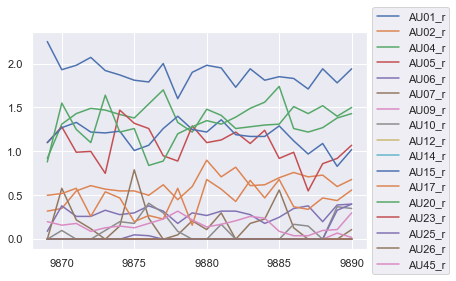

In [153]:
sample = df.drop(columns = ['timestamp','video','gaze_angle_x','gaze_angle_y','pose_Rx','pose_Ry','pose_Rz'])
sample = sample[df['video']==videos[v]]
sample.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

#### Sample Data containing similar signals after processing

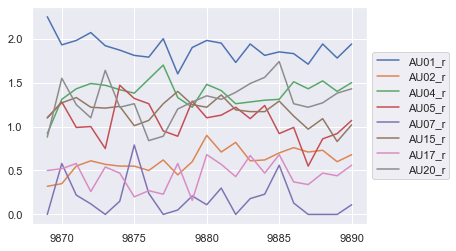

In [154]:
dropLowScoring(v, df).plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

[37, 'AU01_r', 'AU04_r', 'AU15_r']


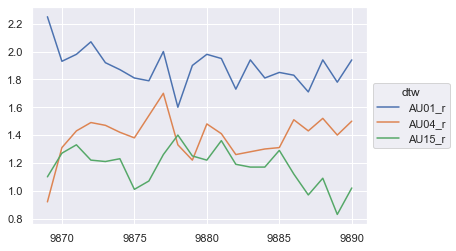

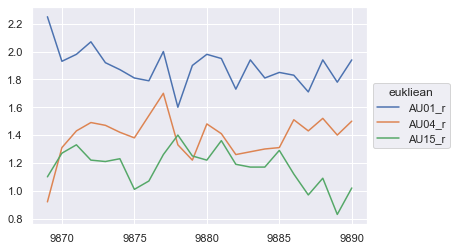

In [155]:
sample = dropLowScoring(v, df)
col = getGroupingDTW(v, df)[1:]
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title = 'dtw');
col = getGroupingAbs(v, df)[1:]
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='eukliean');

#### show video

In [156]:
from IPython.display import Image, display

X = Image(url='sadness_Gif/{}.gif'.format(videos[v]))
display(X)

## Grouping

#### Get AU grouping for entire dataframe

In [157]:
def getGrouping(df):
    groupings = []
    for i in range(len(videos)):
        group = getGroupingDTW(i, df)
        groupings.append(group.copy())
    return groupings

#### Group Similar Clusters together -return cluster dataframe

In [158]:
def groupCluster(groupings):
    data = []
    for i in groupings:
        data.append(i[1:])

    clusters = []
    N = [0]*len(videos)


    for elem in data:
        if len(elem) == 1:
            continue
        if elem not in clusters:
            clusters.append(elem)
        N[clusters.index(elem)] += 1

    N = N[:len(clusters)]

    cluster_df = pd.DataFrame()
    cluster_df['N'] =  N
    cluster_df['clusters'] = clusters
    cluster_df = cluster_df[cluster_df['N'] > 1].sort_values(by=['N'], ascending=False)
    return data, cluster_df


## Find grouping for upper face AU

In [159]:
upper = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU45_r']
lower = ['AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r']
upper_au = df[upper]
lower_au = df[lower]
upper_df = df.drop(columns = lower)
lower_df = df.drop(columns = upper)

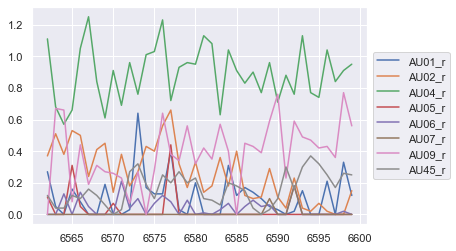

In [160]:
v = 9
sample = upper_au[df['video']==videos[v]]
sample.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

[9, 'AU04_r', 'AU09_r']


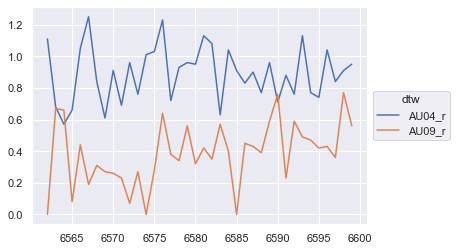

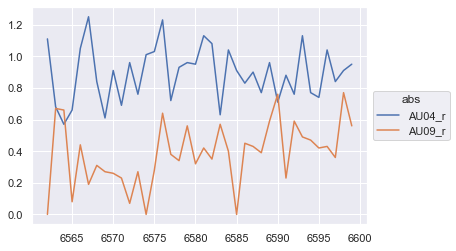

In [161]:
sample = dropLowScoring(v, upper_df)
col = getGroupingDTW(v, upper_df)[1:]
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title = 'dtw');
col = getGroupingAbs(v, upper_df)[1:]
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='abs');

In [162]:
from IPython.display import Image, display

X = Image(url='sadness_Gif/{}.gif'.format(videos[v]))
display(X)

#### Get Grouping Data

Note: this may take a little while to run

In [163]:
upper_groupings = getGrouping(upper_df)

[0, 'AU04_r', 'AU07_r']
[1, 'AU05_r', 'AU07_r', 'AU09_r']
[2, 'AU06_r', 'AU09_r']
[3, 'AU04_r', 'AU45_r']
[4, 'AU01_r', 'AU45_r']
[5, 'AU02_r']
[6, 'AU45_r']
[7, 'AU06_r', 'AU07_r']
[8, 'AU04_r', 'AU06_r']
[9, 'AU04_r', 'AU09_r']
[10, 'AU05_r', 'AU06_r']
[11, 'AU01_r']
[12, 'AU04_r', 'AU06_r', 'AU07_r']
[13, 'AU01_r', 'AU45_r']
[14, 'AU02_r', 'AU05_r']
[15, 'AU07_r', 'AU09_r']
[16, 'AU05_r']
[17, 'AU01_r', 'AU04_r']
[18, 'AU06_r', 'AU09_r']
[19, 'AU01_r', 'AU06_r', 'AU07_r']
[20, 'AU04_r']
[21, 'AU05_r']
[22, 'AU06_r', 'AU09_r']
[23, 'AU07_r']
[24, 'AU01_r', 'AU07_r']
[25, 'AU01_r', 'AU06_r']
[26, 'AU02_r', 'AU05_r']
[27, 'AU05_r', 'AU45_r']
[28, 'AU07_r', 'AU45_r']
[29, 'AU01_r']
[30, 'AU01_r', 'AU02_r', 'AU07_r']
[31, 'AU06_r']
[32, 'AU01_r']
[33, 'AU04_r', 'AU06_r']
[34, 'AU02_r', 'AU05_r']
[35, 'AU04_r', 'AU06_r']
[36, 'AU06_r', 'AU07_r']
[37, 'AU01_r', 'AU04_r']
[38, 'AU06_r', 'AU07_r']
[39, 'AU04_r', 'AU45_r']
[40, 'AU02_r', 'AU09_r']
[41, 'AU01_r', 'AU05_r']
[42, 'AU06_r', 'AU09

[357, 'AU01_r', 'AU45_r']
[358, 'AU01_r', 'AU05_r']
[359, 'AU04_r', 'AU07_r']
[360, 'AU01_r', 'AU45_r']
[361, 'AU07_r']
[362, 'AU06_r', 'AU07_r']
[363, 'AU02_r', 'AU04_r']
[364, 'AU07_r']
[365, 'AU07_r', 'AU09_r']
[366, 'AU01_r', 'AU06_r']
[367, 'AU04_r', 'AU06_r']
[368, 'AU01_r', 'AU04_r']
[369, 'AU01_r', 'AU45_r']
[370, 'AU04_r', 'AU06_r']
[371, 'AU01_r']
[372, 'AU01_r', 'AU05_r']
[373, 'AU45_r']
[374, 'AU01_r', 'AU05_r']
[375, 'AU01_r', 'AU06_r']
[376, 'AU01_r', 'AU02_r']
[377, 'AU02_r']
[378, 'AU04_r', 'AU07_r']
[379, 'AU01_r', 'AU06_r']
[380, 'AU02_r', 'AU04_r']
[381, 'AU05_r', 'AU45_r']
[382, 'AU04_r', 'AU06_r']
[383, 'AU04_r', 'AU06_r', 'AU07_r']
[384, 'AU02_r', 'AU45_r']
[385, 'AU06_r', 'AU07_r', 'AU09_r']
[386, 'AU02_r']
[387, 'AU01_r', 'AU45_r']
[388, 'AU01_r', 'AU09_r']
[389, 'AU01_r', 'AU07_r']
[390, 'AU45_r']
[391, 'AU01_r', 'AU45_r']
[392, 'AU05_r']
[393, 'AU01_r']
[394, 'AU01_r']
[395, 'AU02_r', 'AU06_r']
[396, 'AU02_r', 'AU05_r']
[397, 'AU04_r']
[398, 'AU01_r']
[399, 'A

In [164]:
upper_data, upper_cluster = groupCluster(upper_groupings)
upper_cluster.head()

,N,clusters
12,29,"[AU01_r, AU04_r]"
5,19,"[AU06_r, AU07_r]"
20,17,"[AU01_r, AU05_r]"
6,15,"[AU04_r, AU06_r]"
0,14,"[AU04_r, AU07_r]"


## Cluster by lower face AU

#### Get Grouping Data

In [165]:
lower_groupings = getGrouping(lower_df)

[0, 'AU14_r', 'AU15_r']
[1, 'AU15_r', 'AU17_r', 'AU26_r']
[2, 'AU17_r', 'AU25_r', 'AU26_r']
[3, 'AU17_r', 'AU26_r']
[4, 'AU20_r', 'AU25_r']
[5, 'AU14_r', 'AU17_r']
[6, 'AU26_r']
[7, 'AU23_r', 'AU25_r', 'AU26_r']
[8, 'AU12_r', 'AU25_r']
[9, 'AU15_r', 'AU26_r']
[10, 'AU10_r', 'AU17_r']
[11, 'AU15_r', 'AU20_r']
[12, 'AU12_r', 'AU17_r', 'AU20_r']
[13, 'AU25_r', 'AU26_r']
[14, 'AU14_r', 'AU26_r']
[15, 'AU10_r', 'AU12_r']
[16, 'AU10_r', 'AU15_r']
[17, 'AU17_r', 'AU20_r']
[18, 'AU25_r']
[19, 'AU10_r', 'AU15_r', 'AU23_r']
[20, 'AU20_r']
[21, 'AU15_r', 'AU25_r']
[22, 'AU12_r', 'AU14_r', 'AU23_r']
[23, 'AU10_r', 'AU25_r']
[24, 'AU26_r']
[25, 'AU14_r', 'AU17_r']
[26, 'AU12_r', 'AU14_r', 'AU20_r']
[27, 'AU17_r']
[28, 'AU14_r', 'AU23_r']
[29, 'AU26_r']
[30, 'AU14_r', 'AU20_r', 'AU25_r']
[31, 'AU12_r', 'AU25_r', 'AU26_r']
[32, 'AU20_r']
[33, 'AU15_r', 'AU26_r']
[34, 'AU10_r', 'AU17_r']
[35, 'AU10_r', 'AU25_r']
[36, 'AU15_r', 'AU20_r']
[37, 'AU20_r']
[38, 'AU14_r', 'AU20_r', 'AU25_r']
[39, 'AU10_r']


[327, 'AU10_r', 'AU23_r', 'AU26_r']
[328, 'AU26_r']
[329, 'AU25_r', 'AU26_r']
[330, 'AU14_r', 'AU15_r']
[331, 'AU10_r', 'AU25_r', 'AU26_r']
[332, 'AU26_r']
[333, 'AU10_r']
[334, 'AU10_r', 'AU23_r']
[335, 'AU26_r']
[336, 'AU17_r']
[337, 'AU15_r']
[338, 'AU15_r', 'AU17_r', 'AU23_r']
[339, 'AU10_r', 'AU15_r', 'AU23_r']
[340, 'AU26_r']
[341, 'AU17_r', 'AU20_r']
[342, 'AU15_r', 'AU17_r']
[343, 'AU14_r', 'AU15_r']
[344, 'AU15_r', 'AU26_r']
[345, 'AU26_r']
[346, 'AU15_r', 'AU23_r']
[347, 'AU26_r']
[348, 'AU15_r', 'AU20_r']
[349, 'AU20_r', 'AU25_r']
[350, 'AU10_r', 'AU17_r']
[351, 'AU14_r']
[352, 'AU10_r']
[353, 'AU20_r', 'AU26_r']
[354, 'AU10_r']
[355, 'AU20_r', 'AU25_r']
[356, 'AU17_r', 'AU25_r']
[357, 'AU14_r']
[358, 'AU25_r', 'AU26_r']
[359, 'AU10_r', 'AU12_r']
[360]
[361, 'AU10_r', 'AU14_r']
[362, 'AU10_r']
[363, 'AU17_r']
[364, 'AU10_r', 'AU15_r']
[365, 'AU10_r', 'AU15_r']
[366, 'AU10_r']
[367, 'AU10_r', 'AU17_r', 'AU26_r']
[368, 'AU17_r', 'AU20_r']
[369, 'AU10_r', 'AU12_r', 'AU26_r']
[3

In [166]:
lower_data, lower_cluster = groupCluster(lower_groupings)
lower_cluster.head(10)

,N,clusters
12,19,"[AU25_r, AU26_r]"
8,14,"[AU15_r, AU26_r]"
9,12,"[AU10_r, AU17_r]"
14,10,"[AU10_r, AU12_r]"
10,10,"[AU15_r, AU20_r]"
15,10,"[AU10_r, AU15_r]"
40,9,"[AU10_r, AU20_r]"
44,9,"[AU10_r, AU26_r]"
20,9,"[AU10_r, AU25_r]"
37,8,"[AU15_r, AU17_r]"


## Cluster both data

In [167]:
groupings = getGrouping(df)

[0, 'AU06_r', 'AU14_r', 'AU15_r']
[1, 'AU05_r', 'AU07_r', 'AU09_r', 'AU17_r', 'AU23_r']
[2, 'AU06_r', 'AU09_r', 'AU10_r', 'AU20_r']
[3, 'AU06_r', 'AU09_r', 'AU17_r']
[4, 'AU06_r', 'AU07_r', 'AU25_r']
[5, 'AU01_r', 'AU02_r', 'AU10_r']
[6, 'AU02_r', 'AU45_r']
[7, 'AU04_r', 'AU06_r', 'AU07_r', 'AU12_r', 'AU14_r']
[8, 'AU04_r', 'AU12_r', 'AU14_r']
[9, 'AU09_r', 'AU15_r', 'AU26_r']
[10, 'AU10_r', 'AU14_r', 'AU17_r']
[11, 'AU01_r', 'AU17_r', 'AU20_r']
[12, 'AU06_r', 'AU12_r', 'AU14_r', 'AU17_r', 'AU20_r']
[13, 'AU12_r', 'AU23_r', 'AU25_r', 'AU26_r']
[14, 'AU02_r', 'AU05_r', 'AU12_r']
[15, 'AU07_r', 'AU09_r', 'AU12_r']
[16, 'AU05_r', 'AU07_r', 'AU15_r']
[17, 'AU01_r', 'AU04_r', 'AU17_r', 'AU20_r']
[18, 'AU06_r', 'AU10_r', 'AU25_r']
[19, 'AU01_r', 'AU10_r', 'AU14_r', 'AU15_r', 'AU23_r']
[20, 'AU04_r', 'AU15_r']
[21, 'AU05_r', 'AU26_r']
[22, 'AU06_r', 'AU09_r', 'AU12_r', 'AU14_r', 'AU23_r']
[23, 'AU06_r', 'AU07_r', 'AU25_r']
[24, 'AU01_r', 'AU07_r', 'AU26_r']
[25, 'AU10_r', 'AU12_r', 'AU14_r', 

[214, 'AU01_r', 'AU10_r', 'AU26_r']
[215, 'AU01_r', 'AU02_r', 'AU06_r']
[216, 'AU04_r', 'AU10_r']
[217, 'AU04_r', 'AU15_r', 'AU20_r']
[218, 'AU06_r', 'AU07_r', 'AU25_r']
[219, 'AU04_r', 'AU07_r', 'AU14_r']
[220, 'AU04_r', 'AU06_r', 'AU10_r']
[221, 'AU04_r', 'AU05_r', 'AU10_r']
[222, 'AU04_r', 'AU06_r', 'AU09_r', 'AU12_r', 'AU45_r']
[223, 'AU15_r', 'AU17_r', 'AU26_r']
[224, 'AU04_r', 'AU06_r', 'AU10_r']
[225, 'AU01_r', 'AU12_r', 'AU14_r']
[226, 'AU07_r', 'AU15_r', 'AU26_r']
[227, 'AU05_r']
[228, 'AU01_r', 'AU05_r']
[229, 'AU05_r', 'AU10_r', 'AU25_r']
[230, 'AU05_r', 'AU15_r', 'AU17_r', 'AU23_r', 'AU26_r']
[231, 'AU26_r']
[232, 'AU01_r', 'AU15_r', 'AU25_r']
[233, 'AU07_r', 'AU12_r', 'AU26_r']
[234, 'AU07_r', 'AU25_r', 'AU26_r']
[235, 'AU01_r', 'AU02_r', 'AU04_r', 'AU15_r']
[236, 'AU04_r', 'AU05_r', 'AU25_r']
[237, 'AU10_r', 'AU14_r', 'AU25_r']
[238, 'AU15_r']
[239, 'AU05_r']
[240, 'AU06_r', 'AU07_r', 'AU09_r', 'AU12_r', 'AU23_r']
[241, 'AU01_r', 'AU05_r']
[242, 'AU02_r', 'AU10_r', 'AU26_

In [168]:
full_data, cluster = groupCluster(groupings)
cluster.head(10)

,N,clusters
28,8,"[AU01_r, AU02_r]"
26,5,"[AU15_r, AU17_r, AU45_r]"
112,4,"[AU01_r, AU02_r, AU04_r]"
178,4,"[AU04_r, AU06_r, AU10_r]"
54,3,"[AU01_r, AU06_r, AU10_r]"
118,3,"[AU01_r, AU02_r, AU05_r]"
131,3,"[AU04_r, AU07_r, AU14_r]"
135,3,"[AU10_r, AU26_r]"
137,3,"[AU02_r, AU26_r]"
192,3,"[AU01_r, AU05_r]"


### Graphing AU Relationship

In [169]:
def getRelation(au_data, au_label):
    
    percentage = pd.DataFrame(index = au_label)   
    for au in au_label:
        au_cluster = []
        # for i in lower_au_label:
        for data in au_data:
            if au in data:
                au_cluster.append(data)

        single_au = 0
        other_au = []
        for i in au_cluster:
            if i == [au]:
                single_au += 1
            else:
                for other in i:
                    if other != au:
                        other_au.append(other)

        length = len(other_au) + single_au
        au_percentage = []

        for i in au_label:
            if i == au:
                au_percentage.append(single_au/length)
            else:
                au_percentage.append(other_au.count(i)/length)


        percentage[au] = au_percentage
        percentage.columns.name='main_au'
        percentage.index.name='au_likelihood'
    percentage.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    

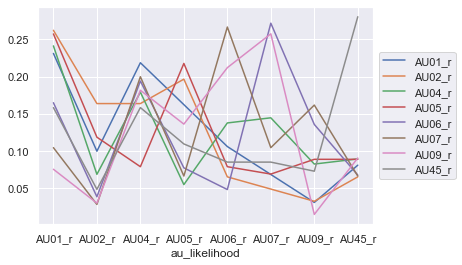

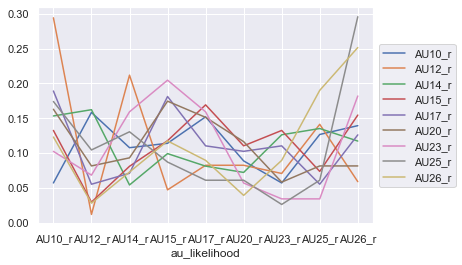

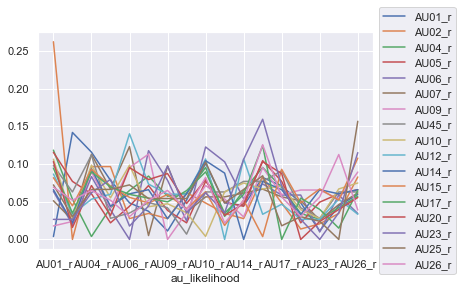

In [170]:
au_label = upper_au.columns.tolist()+lower_au.columns.tolist()

au_data = upper_data
getRelation(upper_data, upper_au.columns.tolist())
getRelation(lower_data, lower_au.columns.tolist())
getRelation(full_data, au_label)

# percentage.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))